In [40]:
# !nvidia-smi

In [41]:
import os
import json
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import math
import glob
from glob import glob

In [42]:
config = {
    "data": {
      "root": "data/daphnet/processed",
      "masking_ratio": 0.5,
      "window_length": 128,
      "overlap": True,
      "segments": 10,
      "batch_size": 64,
      "features": 9
    },
    "training": {
      "work_dir": "experiments/daphnet",
      "masking_ratio": 0.7,
      "lr": 0.01,
      "epochs": 20
    },
    "networks": {
      "time_embedding": 128,
      "feature_embedding": 16,
      "masking_strategy": "random"
    },
    "diffusion": {
      "layers": 4,
      "channels": 64,
      "num_heads": 8,
      "embedding_dim": 128,
      "beta_start": 0.0001,
      "beta_end": 0.5,
      "num_steps": 500,
      "scheduler": "quad",
      "side_dim": 144  # time_embedding + feature_embedding
    },
    "etc": {
      "device": "cuda:0" if torch.cuda.is_available() else "cpu",
      "seed": 42
    }
}

In [43]:
random.seed(config["etc"]["seed"])
np.random.seed(config["etc"]["seed"])
torch.manual_seed(config["etc"]["seed"])
torch.cuda.manual_seed(config["etc"]["seed"]) if torch.cuda.is_available() else None
torch.cuda.manual_seed_all(config["etc"]["seed"]) if torch.cuda.is_available() else None
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(config["etc"]["seed"])

In [44]:
def three_sigma_outlier_removal(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    data_cleaned = np.where(
        (data < lower_bound) | (data > upper_bound), np.median(data, axis=0), data
    )
    return data_cleaned

def normalise_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

# Create directory structure
os.makedirs("data/daphnet/processed", exist_ok=True)
os.makedirs(config["training"]["work_dir"], exist_ok=True)

In [45]:
# def preprocess_daphnet():
#     import numpy as np
#     import random
#     import pickle
#     import os
#     from glob import glob

#     def three_sigma_outlier_removal(data):
#         mean = np.mean(data, axis=0)
#         std = np.std(data, axis=0)
#         return np.clip(data, mean - 3 * std, mean + 3 * std)

#     def normalise_data(data):
#         return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

#     WINDOW_SIZE = 128
#     STRIDE = 64
#     MAX_TRAIN_PER_FILE = 100
#     MAX_TEST_NORMAL_PER_FILE = 20
#     MAX_TEST_ABNORMAL_PER_FILE = 20

#     all_train_windows = []
#     all_train_labels = []
#     all_test_windows = []
#     all_test_labels = []

#     total_records = 0
#     total_windows = 0

#     files = sorted([f for f in glob("data/daphnet/raw/*.txt") if not os.path.basename(f).startswith('.')])
#     print(f"📂 Found {len(files)} files to process.\n")

#     for file_path in files:
#         print(f"📄 Processing {file_path}")
#         data = np.genfromtxt(file_path, delimiter=" ")
#         total_records += len(data)

#         features = data[:, 1:-1]
#         labels = data[:, -1]

#         features = three_sigma_outlier_removal(features)
#         features = normalise_data(features)

#         windows = []
#         window_labels = []

#         for i in range(0, len(features) - WINDOW_SIZE + 1, STRIDE):
#             window_feat = features[i:i + WINDOW_SIZE]
#             window_label = labels[i:i + WINDOW_SIZE]
#             windows.append(window_feat)
#             window_labels.append(window_label)

#         total_windows += len(windows)

#         normal_windows = []
#         abnormal_windows = []

#         for feat, lbl in zip(windows, window_labels):
#             if np.all(lbl == 0):
#                 normal_windows.append((feat, lbl))
#             else:
#                 abnormal_windows.append((feat, lbl))

#         random.shuffle(normal_windows)
#         random.shuffle(abnormal_windows)

#         train_normal = normal_windows[:MAX_TRAIN_PER_FILE]
#         test_normal = normal_windows[MAX_TRAIN_PER_FILE:MAX_TRAIN_PER_FILE + MAX_TEST_NORMAL_PER_FILE]
#         test_abnormal = abnormal_windows[:MAX_TEST_ABNORMAL_PER_FILE]

#         all_train_windows.extend([w[0] for w in train_normal])
#         all_train_labels.extend([w[1] for w in train_normal])

#         all_test_windows.extend([w[0] for w in test_normal + test_abnormal])
#         all_test_labels.extend([w[1] for w in test_normal + test_abnormal])

#         print(f"  🟢 Total normal windows: {len(normal_windows)}")
#         print(f"  🔴 Total abnormal windows: {len(abnormal_windows)}")
#         print(f"    📚 Train normal sampled: {len(train_normal)}")
#         print(f"    🧪 Test normal sampled: {len(test_normal)}")
#         print(f"    🧪 Test abnormal sampled: {len(test_abnormal)}")
#         print(f"    📦 Cumulative → Train: {len(all_train_windows)}, Test: {len(all_test_windows)}\n")

#     print(f"📊 Total records across all files: {total_records}")
#     print(f"📐 Total sliding windows extracted: {total_windows}")

#     final_train_feat = np.vstack(all_train_windows)
#     final_train_lbl = np.concatenate(all_train_labels)
#     final_test_feat = np.vstack(all_test_windows)
#     final_test_lbl = np.concatenate(all_test_labels)

#     print(f"\n📦 Final dataset summary:")
#     print(f"  ✅ Train windows: {len(all_train_windows)}")
#     print(f"  ✅ Test windows: {len(all_test_windows)}")
#     print(f"  🧮 Train features shape: {final_train_feat.shape}, labels: {final_train_lbl.shape}")
#     print(f"  🧮 Test features shape: {final_test_feat.shape}, labels: {final_test_lbl.shape}")
#     abnormal_ratio = np.sum(final_test_lbl > 0) / len(final_test_lbl)
#     print(f"  🔍 Test abnormal ratio: {abnormal_ratio:.2%}")

#     os.makedirs("data/daphnet/processed", exist_ok=True)
#     with open("data/daphnet/processed/daphnet_train.pkl", "wb") as f:
#         pickle.dump(final_train_feat, f)
#     with open("data/daphnet/processed/daphnet_test.pkl", "wb") as f:
#         pickle.dump(final_test_feat, f)
#     with open("data/daphnet/processed/daphnet_test_label.pkl", "wb") as f:
#         pickle.dump(final_test_lbl, f)

#     print("\n💾 All data saved successfully!\n")

In [46]:
def preprocess_daphnet():
    # 초기화
    all_train_features = None
    all_train_labels = None
    all_test_features = None
    all_test_labels = None

    from glob import glob
    items = glob("data/daphnet/raw/*.txt")
    items.sort()
    print(f"Found {len(items)} files")

    for item in items:
        try:
            print(f"Processing {item}...")

            # 파일 내용 확인
            with open(item, 'r') as f:
                first_lines = [next(f) for _ in range(5)]
                print(f"First 5 lines of {item}:")
                for line in first_lines:
                    print(line.strip())

            data = np.genfromtxt(item, delimiter=" ")
            print(f"Data shape after loading: {data.shape}")

            features = data[:, 1:-1]
            print(f"Features shape: {features.shape}")

            features = three_sigma_outlier_removal(features)
            features = normalise_data(features)
            labels = data[:, -1]
            print("Before discarding 0:", features.shape, labels.shape)

            mask = labels != 0
            features = features[mask]
            labels = labels[mask]
            print(f"After mask: features {features.shape}, labels {labels.shape}")

            # 데이터가 충분한지 확인
            if len(features) < 128:
                print(f"Warning: Not enough data in {item} after filtering. Skipping.")
                continue

            features = features[: features.shape[0] // 128 * 128]
            labels = labels[: labels.shape[0] // 128 * 128]
            print("After discarding 0:", features.shape, labels.shape)

            normal_slice = []
            abnormal_slice = []
            for i in range(0, len(labels), 128):
                slice_labels = labels[i : i + 128]
                if np.all(slice_labels == 1):
                    normal_slice.append(i)
                else:
                    abnormal_slice.append(i)
            print(
                f"Normal slices: {len(normal_slice)}, abnormal slices: {len(abnormal_slice)}"
            )

            try:
                test_normal_slice = random.sample(
                    normal_slice,
                    int((len(normal_slice) + len(abnormal_slice)) * 0.3)
                    - len(abnormal_slice),
                )
            except ValueError as e:
                print(f"Error sampling normal slices: {e}")
                test_normal_slice = []

            train_slice = list(set(normal_slice) - set(test_normal_slice))
            test_slice = test_normal_slice + abnormal_slice
            print(f"Train slices: {len(train_slice)} Test slices: {len(test_slice)}")

            if len(train_slice) == 0 or len(test_slice) == 0:
                print(f"Warning: No train or test slices in {item}. Skipping.")
                continue

            train_features = np.vstack([features[i : i + 128] for i in train_slice])
            train_labels = np.hstack([labels[i : i + 128] - 1 for i in train_slice])
            test_features = np.vstack([features[i : i + 128] for i in test_slice])
            test_labels = np.hstack([labels[i : i + 128] - 1 for i in test_slice])

            print(f"Train features shape: {train_features.shape}")
            print(f"Test features shape: {test_features.shape}")

            if all_train_features is None:
                all_train_features = train_features
                all_train_labels = train_labels
                all_test_features = test_features
                all_test_labels = test_labels
            else:
                all_train_features = np.vstack((all_train_features, train_features))
                all_train_labels = np.hstack((all_train_labels, train_labels))
                all_test_features = np.vstack((all_test_features, test_features))
                all_test_labels = np.hstack((all_test_labels, test_labels))

            print(f"Current all_train_features shape: {all_train_features.shape}")
        except Exception as e:
            print(f"Error processing {item}: {str(e)}")
            import traceback
            traceback.print_exc()
            print("Continuing with next file...")
            continue

    # 최종 결과 확인
    if all_train_features is not None:
        print("Final shapes:")
        print(all_train_features.shape, all_train_labels.shape)
        print(all_test_features.shape, all_test_labels.shape)

        # 저장 디렉토리 확인 및 생성
        import os
        os.makedirs("data/daphnet/processed", exist_ok=True)

        # 저장
        with open("data/daphnet/processed/daphnet_train.pkl", "wb") as f:
            pickle.dump((all_train_features), f)
        with open("data/daphnet/processed/daphnet_test.pkl", "wb") as f:
            pickle.dump((all_test_features), f)
        with open("data/daphnet/processed/daphnet_test_label.pkl", "wb") as f:
            pickle.dump((all_test_labels), f)
        print("Data saved successfully!")
    else:
        print("No data was processed successfully. Check the errors above.")

In [47]:
import os
print(os.listdir("data/daphnet/raw"))
items = glob("data/daphnet/raw/*.txt")
print("Found files:", items)

preprocess_daphnet()

['S02R01.txt', 'S02R02.txt', 'S01R01.txt', 'S01R02.txt']
Found files: ['data/daphnet/raw/S02R01.txt', 'data/daphnet/raw/S02R02.txt', 'data/daphnet/raw/S01R01.txt', 'data/daphnet/raw/S01R02.txt']
Found 4 files
Processing data/daphnet/raw/S01R01.txt...
First 5 lines of data/daphnet/raw/S01R01.txt:
15 70 39 -970 0 0 0 0 0 0 0
31 70 39 -970 0 0 0 0 0 0 0
46 60 49 -960 0 0 0 0 0 0 0
62 60 49 -960 0 0 0 0 0 0 0
78 50 39 -960 0 0 0 0 0 0 0
Data shape after loading: (151987, 11)
Features shape: (151987, 9)
Before discarding 0: (151987, 9) (151987,)
After mask: features (92802, 9), labels (92802,)
After discarding 0: (92800, 9) (92800,)
Normal slices: 667, abnormal slices: 58
Train slices: 508 Test slices: 217
Train features shape: (65024, 9)
Test features shape: (27776, 9)
Current all_train_features shape: (65024, 9)
Processing data/daphnet/raw/S01R02.txt...
First 5 lines of data/daphnet/raw/S01R02.txt:
15 40 29 -960 0 0 0 0 0 0 0
31 70 49 -960 0 0 0 0 0 0 0
46 60 29 -970 0 0 0 0 0 0 0
62 60 2

In [48]:
# Dataset class for Daphnet
class DaphnetDataset(Dataset):
    def __init__(self, config, mode="train", strategy_type=None):
        self.config = config
        self.root = config["data"]["root"]
        self.mode = mode
        self.strategy_type = strategy_type

        self.data = pickle.load(open(f"{self.root}/daphnet_{self.mode}.pkl", "rb"))
        self.label = np.zeros((self.data.shape[0]))
        if self.mode == "test":
            self.label = pickle.load(
                open(f"{self.root}/daphnet_{self.mode}_label.pkl", "rb")
            )
        self.data = torch.Tensor(self.data)
        self.label = torch.LongTensor(self.label)

        self.window_length = config["data"]["window_length"]
        self.begin_indices = None
        if config["data"]["overlap"]:
            self.begin_indices = list(range(0, len(self.data) - self.window_length))
        if not config["data"]["overlap"]:
            self.begin_indices = list(range(0, len(self.data), self.window_length))

        self.segments = config["data"]["segments"]

    def create_mask(self, observed_mask, strategy_type):
        mask = torch.zeros_like(observed_mask)
        length = observed_mask.shape[0]
        if strategy_type == 0:
            skip = length // self.segments
            for segment_idx, begin_index in enumerate(list(range(0, length, skip))):
                if segment_idx % 2 == 0:
                    mask[begin_index : min(begin_index + skip, length), :] = 1
        else:
            skip = length // self.segments
            for segment_idx, begin_index in enumerate(list(range(0, length, skip))):
                if segment_idx % 2 != 0:
                    mask[begin_index : min(begin_index + skip, length), :] = 1
        return mask

    def __len__(self):
        return len(self.begin_indices)

    def __getitem__(self, idx):
        if self.mode == "train":
            if random.random() < 0.5:
                strategy_type = 0
            else:
                strategy_type = 1
        elif self.mode == "test":
            strategy_type = self.strategy_type

        observed_data = self.data[
            self.begin_indices[idx] : self.begin_indices[idx] + self.window_length
        ]
        observed_mask = torch.ones_like(observed_data)
        gt_mask = self.create_mask(observed_mask, strategy_type)
        timepoints = np.arange(self.window_length)
        label = self.label[
            self.begin_indices[idx] : self.begin_indices[idx] + self.window_length
        ]

        return {
            "observed_data": observed_data,
            "observed_mask": observed_mask,
            "gt_mask": gt_mask,
            "strategy_type": strategy_type,
            "timepoints": timepoints,
            "label": label,
        }

In [49]:
# Get dataloaders
def get_dataloader(config):
    train_ds = DaphnetDataset(config, mode="train")
    train_ds, val_ds = random_split(
        train_ds,
        [len(train_ds) - int(0.05 * len(train_ds)), int(0.05 * len(train_ds))],
    )
    test_0_ds = DaphnetDataset(config, mode="test", strategy_type=0)
    test_1_ds = DaphnetDataset(config, mode="test", strategy_type=1)

    train_dl = DataLoader(
        train_ds, batch_size=config["data"]["batch_size"], shuffle=True
    )
    val_dl = DataLoader(val_ds, batch_size=config["data"]["batch_size"], shuffle=True)
    test_0_dl = DataLoader(
        test_0_ds, batch_size=config["data"]["batch_size"], shuffle=False
    )
    test_1_dl = DataLoader(
        test_1_ds, batch_size=config["data"]["batch_size"], shuffle=False
    )

    return train_dl, val_dl, test_0_dl, test_1_dl


In [50]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim=128, projection_dim=None):
        super().__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim // 2),
            persistent=False,
        )
        self.proj_1 = nn.Linear(embedding_dim, projection_dim)
        self.proj_2 = nn.Linear(projection_dim, projection_dim)

    def forward(self, t):
        x = self.embedding[t]
        x = self.proj_1(x)
        x = F.silu(x)
        x = self.proj_2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T, 1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(
            0
        )  # (1, dim)
        table = steps * frequencies  # (T, dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T, dim * 2)
        return table

In [51]:
def transformer(heads=8, layers=1, channels=64):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=channels, nhead=heads, dim_feedforward=64, activation="gelu"
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=layers)

def conv1d(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer


In [52]:
class ResidualBlock(nn.Module):
    def __init__(self, side_dim, channels, embedding_dim, nheads):
        super().__init__()
        self.diffusion_projection = nn.Linear(embedding_dim, channels)
        self.strategy_projection = nn.Linear(embedding_dim, channels)

        self.cond_projection = conv1d(side_dim, 2 * channels, 1)
        self.mid_projection = conv1d(channels, 2 * channels, 1)
        self.output_projection = conv1d(channels, 2 * channels, 1)

        self.time_layer = transformer(heads=nheads, layers=1, channels=channels)
        self.feature_layer = transformer(heads=nheads, layers=1, channels=channels)

    def forward_time(self, y, base_shape):
        B, channel, K, L = base_shape
        if L == 1:
            return y
        y = y.reshape(B, channel, K, L).permute(0, 2, 1, 3).reshape(B * K, channel, L)
        y = self.time_layer(y.permute(2, 0, 1)).permute(1, 2, 0)
        y = y.reshape(B, K, channel, L).permute(0, 2, 1, 3).reshape(B, channel, K * L)
        return y

    def forward_feature(self, y, base_shape):
        B, channel, K, L = base_shape
        if K == 1:
            return y
        y = y.reshape(B, channel, K, L).permute(0, 3, 1, 2).reshape(B * L, channel, K)
        y = self.feature_layer(y.permute(2, 0, 1)).permute(1, 2, 0)
        y = y.reshape(B, L, channel, K).permute(0, 2, 3, 1).reshape(B, channel, K * L)
        return y

    def forward(self, x, cond_info, diffusion_emb, strategy_emb):
        B, channel, K, L = x.shape
        base_shape = x.shape
        x = x.reshape(B, channel, K * L)

        diffusion_emb = self.diffusion_projection(diffusion_emb).unsqueeze(
            -1
        )  # (B, channel, 1)
        strategy_emb = self.strategy_projection(strategy_emb).unsqueeze(-1)

        y = x + diffusion_emb + strategy_emb

        y = self.forward_time(y, base_shape)
        y = self.forward_feature(y, base_shape)  # (B, channel, K * L)
        y = self.mid_projection(y)  # (B, 2 * channel, K * L)

        _, cond_dim, _, _ = cond_info.shape
        cond_info = cond_info.reshape(B, cond_dim, K * L)
        cond_info = self.cond_projection(cond_info)  # (B, 2 * channel, K * L)
        y = y + cond_info

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (B, channel, K * L)
        y = self.output_projection(y)

        residual, skip = torch.chunk(y, 2, dim=1)
        x = x.reshape(base_shape)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)

        return (x + residual) / math.sqrt(2.0), skip

In [53]:
class DiffusionBackbone(nn.Module):
    def __init__(self, config, input_dim=2):
        super().__init__()
        self.channels = config["diffusion"]["channels"]

        self.diffusion_embedding = DiffusionEmbedding(
            num_steps=config["diffusion"]["num_steps"],
            embedding_dim=config["diffusion"]["embedding_dim"],
        )
        self.strategy_embedding = nn.Embedding(2, config["diffusion"]["embedding_dim"])

        self.input_projection = conv1d(input_dim, self.channels, 1)
        self.output_projection1 = conv1d(self.channels, self.channels, 1)
        self.output_projection2 = conv1d(self.channels, 1, 1)
        nn.init.zeros_(self.output_projection2.weight)

        self.residual_layers = nn.ModuleList(
            [
                ResidualBlock(
                    side_dim=config["diffusion"]["side_dim"],
                    channels=self.channels,
                    embedding_dim=config["diffusion"]["embedding_dim"],
                    nheads=config["diffusion"]["num_heads"],
                )
                for _ in range(config["diffusion"]["layers"])
            ]
        )

    def forward(self, x, cond_info, diffusion_step, strategy_type):
        B, inputdim, K, L = x.shape

        x = x.reshape(B, inputdim, K * L)
        x = self.input_projection(x)
        x = F.relu(x)
        x = x.reshape(B, self.channels, K, L)

        diffusion_emb = self.diffusion_embedding(diffusion_step)
        strategy_emb = self.strategy_embedding(strategy_type)
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, cond_info, diffusion_emb, strategy_emb)
            skip.append(skip_connection)

        x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        x = x.reshape(B, self.channels, K * L)
        x = self.output_projection1(x)  # (B, channel, K * L)
        x = F.relu(x)
        x = self.output_projection2(x)  # (B, 1, K * L)
        x = x.reshape(B, K, L)
        return x

In [54]:
class CSDI(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.config = config

        self.ddim_eta = 1
        self.target_dim = config["data"]["features"]

        self.emb_time_dim = config["networks"]["time_embedding"]
        self.emb_feature_dim = config["networks"]["feature_embedding"]
        self.masking_strategy = config["networks"]["masking_strategy"]
        self.masking_ratio = config["training"]["masking_ratio"]

        self.emb_total_dim = self.emb_time_dim + self.emb_feature_dim
        self.embed_layer = nn.Embedding(
            num_embeddings=self.target_dim, embedding_dim=self.emb_feature_dim
        )

        config["diffusion"]["side_dim"] = self.emb_total_dim
        input_dim = 1
        self.diffusion_backbone = DiffusionBackbone(config=config, input_dim=input_dim)

        self.num_steps = config["diffusion"]["num_steps"]
        if config["diffusion"]["scheduler"] == "quad":
            self.beta = (
                np.linspace(
                    config["diffusion"]["beta_start"] ** 0.5,
                    config["diffusion"]["beta_end"] ** 0.5,
                    self.num_steps,
                )
                ** 2
            )
        elif config["diffusion"]["scheduler"] == "linear":
            self.beta = np.linspace(
                config["diffusion"]["beta_start"],
                config["diffusion"]["beta_end"],
                self.num_steps,
            )

        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_tensor = (
            torch.tensor(self.alpha).float().to(self.device).unsqueeze(1).unsqueeze(1)
        )

    def _process_batch(self, data):
        observed_data = data["observed_data"].to(self.device).float()
        observed_mask = data["observed_mask"].to(self.device).float()
        observed_timepoint = data["timepoints"].to(self.device).float()
        gt_mask = data["gt_mask"].to(self.device).float()

        observed_data = observed_data.permute(0, 2, 1)
        observed_mask = observed_mask.permute(0, 2, 1)
        gt_mask = gt_mask.permute(0, 2, 1)

        cut_length = torch.zeros(len(observed_data)).long().to(self.device)
        for_pattern_mask = observed_mask

        strategy_type = data["strategy_type"].to(self.device).long()

        return (
            observed_data,
            observed_mask,
            observed_timepoint,
            gt_mask,
            for_pattern_mask,
            cut_length,
            strategy_type,
        )

    def _create_random_mask(self, observed_mask):
        rand_for_mask = torch.rand_like(observed_mask) * observed_mask
        rand_for_mask = rand_for_mask.reshape(len(rand_for_mask), -1)  # (b, *)
        for i in range(len(observed_mask)):
            num_observed = observed_mask[i].sum().item()
            num_masked = round(num_observed * self.masking_ratio)
            rand_for_mask[i][rand_for_mask[i].topk(num_masked).indices] = -1
        conditioned_mask = (rand_for_mask > 0).reshape(observed_mask.shape).float()
        return conditioned_mask

    def _create_historical_mask(self, observed_mask, for_pattern_mask):
        if for_pattern_mask is None:
            for_pattern_mask = observed_mask
        if self.masking_strategy == "mix":
            random_mask = self._create_random_mask(observed_mask)
        conditioned_mask = observed_mask.clone()
        for i in range(len(conditioned_mask)):
            mask_choice = np.random.rand()
            if self.masking_strategy == "mix" and mask_choice > 0.5:
                conditioned_mask[i] = random_mask[i]
            else:
                conditioned_mask[i] = conditioned_mask[i] * for_pattern_mask[i - 1]
        return conditioned_mask

    def _time_embedding(self, pos, d_model=128):
        pe = torch.zeros(pos.shape[0], pos.shape[1], d_model).to(self.device)
        position = pos.unsqueeze(2)
        div_term = 1 / torch.pow(
            10000.0, torch.arange(0, d_model, 2).to(self.device) / d_model
        )
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

    def _get_auxiliary_info(self, observed_timepoint, conditioned_mask):
        B, K, L = conditioned_mask.shape

        time_embed = self._time_embedding(
            observed_timepoint, self.emb_time_dim
        )  # (B, L, emb)
        time_embed = time_embed.unsqueeze(2).expand(-1, -1, K, -1)
        feature_embed = self.embed_layer(
            torch.arange(self.target_dim).to(self.device)
        )  # (K, emb)
        feature_embed = feature_embed.unsqueeze(0).unsqueeze(0).expand(B, L, -1, -1)

        aux_info = torch.cat([time_embed, feature_embed], dim=-1)  # (B, L, K, *)
        aux_info = aux_info.permute(0, 3, 2, 1)  # (B, *, K, L)

        return aux_info

    def _calculate_loss(
        self,
        observed_data,
        conditioned_mask,
        observed_mask,
        aux_info,
        train,
        strategy_type,
        set_t=-1,
    ):
        B, K, L = observed_data.shape
        if not train:
            t = (torch.ones(B) * set_t).long().to(self.device)
        else:
            t = torch.randint(0, self.num_steps, [B]).to(self.device)
        current_alpha = self.alpha_tensor[t]  # (B, 1, 1)
        noise = torch.randn_like(observed_data)
        noisy_data = (current_alpha**0.5) * observed_data + (
            1.0 - current_alpha
        ) ** 0.5 * noise
        total_input = noisy_data.unsqueeze(1)  # (B, 1, K, L)

        prediction = self.diffusion_backbone(total_input, aux_info, t, strategy_type)
        target_mask = observed_mask - conditioned_mask

        residual = (prediction - observed_data) * target_mask
        num_eval = target_mask.sum()
        loss = (residual**2).sum() / (num_eval if num_eval > 0 else 1)

        return loss

    def _calculate_cumulative_loss(
        self,
        observed_data,
        conditioned_mask,
        observed_mask,
        aux_info,
        train,
        strategy_type,
    ):
        loss_sum = 0
        for t in range(self.num_steps):
            loss = self._calculate_loss(
                observed_data,
                conditioned_mask,
                observed_mask,
                aux_info,
                train,
                strategy_type,
                set_t=t,
            )
            loss_sum += loss.detach()
        return loss_sum / self.num_steps

    def forward(self, data, train=False):
        (
            observed_data,
            observed_mask,
            observed_timepoint,
            gt_mask,
            for_pattern_mask,
            _,  # cut_length
            strategy_type,
        ) = self._process_batch(data)

        if not train:
            conditioned_mask = gt_mask
        elif self.masking_strategy != "random":
            conditioned_mask = self._create_historical_mask(
                observed_mask, for_pattern_mask
            )
        else:
            conditioned_mask = self._create_random_mask(observed_mask)

        aux_info = self._get_auxiliary_info(observed_timepoint, conditioned_mask)
        loss_function = (
            self._calculate_loss if train else self._calculate_cumulative_loss
        )
        loss = loss_function(
            observed_data,
            conditioned_mask,
            observed_mask,
            aux_info,
            train,
            strategy_type,
        )
        return loss

    def _impute(
        self, observed_data, conditioned_mask, aux_info, n_samples, strategy_type
    ):
        B, K, L = observed_data.shape

        imputed_samples = torch.zeros(B, n_samples, K, L).to(self.device)
        for i in range(n_samples):
            noisy_obs = observed_data
            noisy_cond_history = []
            for t in range(self.num_steps):
                noise = torch.randn_like(noisy_obs)
                noisy_obs = (self.alpha_hat[t] ** 0.5) * noisy_obs + self.beta[
                    t
                ] ** 0.5 * noise
                noisy_cond_history.append(noisy_obs * conditioned_mask)
            current_sample = torch.randn_like(observed_data)

            for t in range(self.num_steps - 1, -1, -1):
                diffusion_input = (
                    conditioned_mask * noisy_cond_history[t]
                    + (1.0 - conditioned_mask) * current_sample
                )
                diffusion_input = diffusion_input.unsqueeze(1)  # (B, 1, K, L)
                predicted = self.diffusion_backbone(
                    diffusion_input,
                    aux_info,
                    torch.tensor([t]).to(self.device),
                    strategy_type,
                )

                coeff_1 = 1 / self.alpha_hat[t] ** 0.5
                coeff_2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                current_sample = coeff_1 * (current_sample - coeff_2 * predicted)

                if t > 0:
                    noise = torch.randn_like(current_sample)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    current_sample += sigma * noise
            imputed_samples[:, i] = current_sample.detach()

        return imputed_samples

    def evaluate(self, data, n_samples):
        (
            observed_data,
            observed_mask,
            observed_timepoint,
            gt_mask,
            _,  # for_pattern_mask
            cut_length,
            strategy_type,
        ) = self._process_batch(data)

        with torch.no_grad():
            conditioned_mask = gt_mask
            target_mask = observed_mask - conditioned_mask
            aux_info = self._get_auxiliary_info(observed_timepoint, conditioned_mask)
            samples = self._impute(
                observed_data, conditioned_mask, aux_info, n_samples, strategy_type
            )
            for i in range(len(cut_length)):  # to avoid double evaluation
                target_mask[i, ..., 0 : cut_length[i].item()] = 0
            return (
                samples,
                observed_data,
                target_mask,
                observed_mask,
                observed_timepoint,
            )

In [55]:
device = torch.device(config["etc"]["device"])
train_dl, val_dl, test_0_dl, test_1_dl = get_dataloader(config)
# Initialize model, optimizer, and learning rate scheduler
net = CSDI(config, device).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=config["training"]["lr"], weight_decay=1e-6)
p1 = int(0.75 * config["training"]["epochs"])
p2 = int(0.9 * config["training"]["epochs"])
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[p1, p2], gamma=0.1
)

# def train(net, train_dl, optimizer, lr_scheduler, epoch):
#     avg_loss = 0
#     net.train()
#     with tqdm(
#         train_dl,
#         desc=f"Epoch {epoch}",
#         dynamic_ncols=True, 
#         mininterval=10, 
#         leave=False
#     ) as it:
#         for batch_idx, data in enumerate(it, start=1):
#             optimizer.zero_grad()
#             loss = net(data, train=True)
#             loss.backward()
#             optimizer.step()
#             avg_loss += loss.item()
#             it.set_postfix({
#                 "avg_loss": f"{avg_loss / batch_idx:.4f}"
#             }, refresh=False)
#     lr_scheduler.step()
#     return avg_loss / len(train_dl)

def validate(net, val_dl, n_samples=5):
    with torch.no_grad():
        net.eval()
        mse_total = 0
        mae_total = 0
        evalpoints_total = 0
        with tqdm(
            val_dl,
            desc="Validating",
            dynamic_ncols=True,
            mininterval=10, 
            leave=False
        ) as it:
            for batch_idx, data in enumerate(it, start=1):
                output = net.evaluate(data, n_samples)
                # Fix the unpacking
                samples, c_target, eval_points = output[0], output[1], output[2]
                samples = samples.permute(0, 1, 3, 2)
                c_target = c_target.permute(0, 2, 1)
                eval_points = eval_points.permute(0, 2, 1)
                samples_median = samples.median(dim=1)
                mse_current = ((samples_median.values - c_target) * eval_points) ** 2
                mae_current = torch.abs((samples_median.values - c_target) * eval_points)
                mse_total += mse_current.sum().item()
                mae_total += mae_current.sum().item()
                evalpoints_total += eval_points.sum().item()
    return mse_total / evalpoints_total

# # Create directory for saving models if it doesn't exist
# os.makedirs(config['training']['work_dir'], exist_ok=True)

# patience = 0

# last_epoch_model_path = ""

# with tqdm(range(1, config["training"]["epochs"] + 1)) as it:
#     for epoch in it:
#         train_mse_score = train(net, train_dl, optimizer, lr_scheduler, epoch)
#         val_mse_score = validate(net, val_dl, 1)
        
#         epoch_output_path = f"{config['training']['work_dir']}/model_epoch_{epoch}.pth"
#         torch.save(net.state_dict(), epoch_output_path)
        
#         last_epoch_model_path = epoch_output_path
        
#         it.set_postfix(
#             ordered_dict={
#                 "train mse": train_mse_score,
#                 "val mse": val_mse_score,
#                 "epoch": epoch,
#             },
#             refresh=False,
#         )
        

# if os.path.exists(last_epoch_model_path):
#     net.load_state_dict(torch.load(last_epoch_model_path))
#     print(f"Last epoch model loaded successfully from {last_epoch_model_path}!")
#     # Evaluate on test data
#     test_mse_score_0 = validate(net, test_0_dl, 20)
#     test_mse_score_1 = validate(net, test_1_dl, 20)
#     print(f"Test MSE (Strategy 0): {test_mse_score_0}")
#     print(f"Test MSE (Strategy 1): {test_mse_score_1}")
# else:
#     print("No saved model found. Please train the model first.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [56]:
# net.load_state_dict(torch.load(last_epoch_model_path))
# print(f"Last epoch model loaded successfully from {last_epoch_model_path}!")

# # test_mse_score_0 = validate(net, test_0_dl, 5)
# # test_mse_score_1 = validate(net, test_1_dl, 5)
# # print(f"Test MSE (Strategy 0): {test_mse_score_0}")
# # print(f"Test MSE (Strategy 1): {test_mse_score_1}")

Loading original test data...
Test features shape: (63488, 9)
Test labels shape: (63488,)
Test features dtype: float64
Test labels dtype: float64
Unique labels in test data: [0. 1.]
Number of normal samples (label=0): 45185
Number of abnormal samples (label>0): 18303
Abnormal ratio: 0.2883


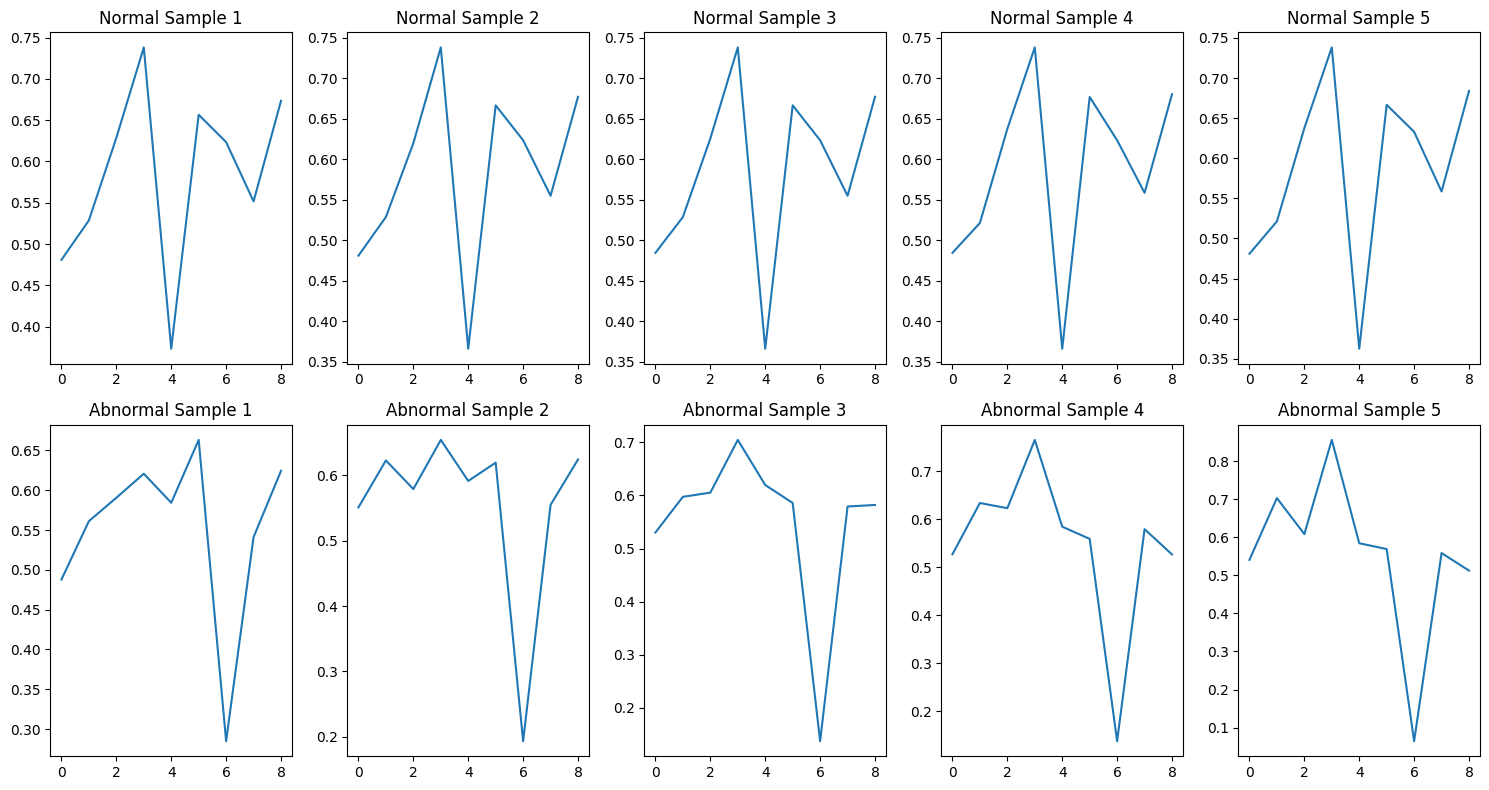


Creating smaller datasets for detailed inspection...
Normal subset: (1000, 9)
Abnormal subset: (1000, 9)
Created 7 normal windows
Created 7 abnormal windows

Inspecting normal windows:
Normal window 0: {0.0: 128}
Normal window 1: {0.0: 128}
Normal window 2: {0.0: 128}
Normal window 3: {0.0: 128}
Normal window 4: {0.0: 128}

Inspecting abnormal windows:
Abnormal window 0: {1.0: 128}
Abnormal window 1: {1.0: 128}
Abnormal window 2: {1.0: 128}
Abnormal window 3: {1.0: 128}
Abnormal window 4: {1.0: 128}

Created 7 normal tensors and 7 abnormal tensors

Normal sample format for model input:
Data shape: torch.Size([128, 9])
Observation mask shape: torch.Size([128, 9])
GT mask shape: torch.Size([128, 9])

Abnormal sample format for model input:
Data shape: torch.Size([128, 9])
Observation mask shape: torch.Size([128, 9])
GT mask shape: torch.Size([128, 9])

Sample model inputs ready for evaluation
Normal input keys: ['observed_data', 'observed_mask', 'gt_mask', 'strategy_type', 'timepoints',

In [57]:
# Detailed data inspection for DaphNet Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import display

# 1. Load the original test data
print("Loading original test data...")
with open("data/daphnet/processed/daphnet_test.pkl", "rb") as f:
    test_features = pickle.load(f)
with open("data/daphnet/processed/daphnet_test_label.pkl", "rb") as f:
    test_labels = pickle.load(f)

print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test features dtype: {test_features.dtype}")
print(f"Test labels dtype: {test_labels.dtype}")
print(f"Unique labels in test data: {np.unique(test_labels)}")
print(f"Number of normal samples (label=0): {np.sum(test_labels == 0)}")
print(f"Number of abnormal samples (label>0): {np.sum(test_labels > 0)}")
print(f"Abnormal ratio: {np.mean(test_labels > 0):.4f}")

# 2. Visualize the first few samples
plt.figure(figsize=(15, 8))
# Plot first 5 normal samples
normal_indices = np.where(test_labels == 0)[0]
for i in range(min(5, len(normal_indices))):
    plt.subplot(2, 5, i+1)
    sample_idx = normal_indices[i]
    plt.plot(test_features[sample_idx])
    plt.title(f"Normal Sample {i+1}")
    plt.tight_layout()

# Plot first 5 abnormal samples
abnormal_indices = np.where(test_labels > 0)[0]
for i in range(min(5, len(abnormal_indices))):
    plt.subplot(2, 5, i+6)
    sample_idx = abnormal_indices[i]
    plt.plot(test_features[sample_idx])
    plt.title(f"Abnormal Sample {i+1}")
    plt.tight_layout()

plt.show()

# 3. Create smaller datasets for detailed inspection
print("\nCreating smaller datasets for detailed inspection...")
max_samples = 1000  # Adjust based on memory requirements
normal_indices_subset = normal_indices[:min(max_samples, len(normal_indices))]
abnormal_indices_subset = abnormal_indices[:min(max_samples, len(abnormal_indices))]

normal_features = test_features[normal_indices_subset]
normal_labels = test_labels[normal_indices_subset]
abnormal_features = test_features[abnormal_indices_subset]
abnormal_labels = test_labels[abnormal_indices_subset]

print(f"Normal subset: {normal_features.shape}")
print(f"Abnormal subset: {abnormal_features.shape}")

# 4. Check distribution of labels in windows
window_size = 128
normal_windows = []
abnormal_windows = []

# Create normal windows
for i in range(0, len(normal_features) - window_size + 1, window_size):
    window_labels = normal_labels[i:i+window_size]
    if np.all(window_labels == 0):
        normal_windows.append((normal_features[i:i+window_size], window_labels))

# Create abnormal windows
for i in range(0, len(abnormal_features) - window_size + 1, window_size):
    window_labels = abnormal_labels[i:i+window_size]
    if np.any(window_labels > 0):
        abnormal_windows.append((abnormal_features[i:i+window_size], window_labels))

print(f"Created {len(normal_windows)} normal windows")
print(f"Created {len(abnormal_windows)} abnormal windows")

# 5. Detailed inspection of windows
print("\nInspecting normal windows:")
for i in range(min(5, len(normal_windows))):
    _, labels = normal_windows[i]
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    print(f"Normal window {i}: {label_counts}")

print("\nInspecting abnormal windows:")
for i in range(min(5, len(abnormal_windows))):
    _, labels = abnormal_windows[i]
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    print(f"Abnormal window {i}: {label_counts}")

# 6. Create tensors for model input
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Convert windows to tensors
normal_tensors = []
for features, _ in normal_windows[:10]:  # Limit to 10 for demonstration
    normal_tensors.append(torch.tensor(features, dtype=torch.float32))

abnormal_tensors = []
for features, _ in abnormal_windows[:10]:  # Limit to 10 for demonstration
    abnormal_tensors.append(torch.tensor(features, dtype=torch.float32))

print(f"\nCreated {len(normal_tensors)} normal tensors and {len(abnormal_tensors)} abnormal tensors")

# 7. Setup model inputs in the right format for one window
if len(normal_tensors) > 0 and len(abnormal_tensors) > 0:
    # Format for normal sample
    normal_data = normal_tensors[0]
    normal_obs_mask = torch.ones_like(normal_data)
    
    # Create gt_mask based on strategy (using the same logic as in DaphnetDataset)
    normal_gt_mask = torch.zeros_like(normal_obs_mask)
    segments = 10  # Same as in config
    skip = window_size // segments
    for segment_idx, begin_index in enumerate(range(0, window_size, skip)):
        if segment_idx % 2 == 0:
            normal_gt_mask[begin_index:min(begin_index+skip, window_size), :] = 1
    
    # Format for abnormal sample
    abnormal_data = abnormal_tensors[0]
    abnormal_obs_mask = torch.ones_like(abnormal_data)
    
    # Create gt_mask for abnormal
    abnormal_gt_mask = torch.zeros_like(abnormal_obs_mask)
    for segment_idx, begin_index in enumerate(range(0, window_size, skip)):
        if segment_idx % 2 == 0:
            abnormal_gt_mask[begin_index:min(begin_index+skip, window_size), :] = 1
    
    print("\nNormal sample format for model input:")
    print(f"Data shape: {normal_data.shape}")
    print(f"Observation mask shape: {normal_obs_mask.shape}")
    print(f"GT mask shape: {normal_gt_mask.shape}")
    
    print("\nAbnormal sample format for model input:")
    print(f"Data shape: {abnormal_data.shape}")
    print(f"Observation mask shape: {abnormal_obs_mask.shape}")
    print(f"GT mask shape: {abnormal_gt_mask.shape}")
    
    # 8. Create sample inputs that would be passed to the model's evaluate method
    normal_input = {
        "observed_data": normal_data.unsqueeze(0),  # Add batch dimension
        "observed_mask": normal_obs_mask.unsqueeze(0),
        "gt_mask": normal_gt_mask.unsqueeze(0),
        "strategy_type": 0,
        "timepoints": np.arange(window_size),
        "label": torch.zeros(window_size, dtype=torch.long)
    }
    
    abnormal_input = {
        "observed_data": abnormal_data.unsqueeze(0),  # Add batch dimension
        "observed_mask": abnormal_obs_mask.unsqueeze(0),
        "gt_mask": abnormal_gt_mask.unsqueeze(0),
        "strategy_type": 0,
        "timepoints": np.arange(window_size),
        "label": torch.ones(window_size, dtype=torch.long)  # Set all to 1 for simplicity
    }
    
    print("\nSample model inputs ready for evaluation")
    print(f"Normal input keys: {list(normal_input.keys())}")
    print(f"Abnormal input keys: {list(abnormal_input.keys())}")

In [58]:
model_path = "./experiments/daphnet/model_epoch_35.pth"
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
print(f"Model loaded successfully from {model_path}")

RuntimeError: Error(s) in loading state_dict for CSDI:
	Missing key(s) in state_dict: "diffusion_backbone.residual_layers.2.diffusion_projection.weight", "diffusion_backbone.residual_layers.2.diffusion_projection.bias", "diffusion_backbone.residual_layers.2.strategy_projection.weight", "diffusion_backbone.residual_layers.2.strategy_projection.bias", "diffusion_backbone.residual_layers.2.cond_projection.weight", "diffusion_backbone.residual_layers.2.cond_projection.bias", "diffusion_backbone.residual_layers.2.mid_projection.weight", "diffusion_backbone.residual_layers.2.mid_projection.bias", "diffusion_backbone.residual_layers.2.output_projection.weight", "diffusion_backbone.residual_layers.2.output_projection.bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.self_attn.in_proj_weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.self_attn.in_proj_bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.self_attn.out_proj.weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.self_attn.out_proj.bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.linear1.weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.linear1.bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.linear2.weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.linear2.bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.norm1.weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.norm1.bias", "diffusion_backbone.residual_layers.2.time_layer.layers.0.norm2.weight", "diffusion_backbone.residual_layers.2.time_layer.layers.0.norm2.bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.self_attn.in_proj_weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.self_attn.in_proj_bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.self_attn.out_proj.weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.self_attn.out_proj.bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.linear1.weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.linear1.bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.linear2.weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.linear2.bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.norm1.weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.norm1.bias", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.norm2.weight", "diffusion_backbone.residual_layers.2.feature_layer.layers.0.norm2.bias", "diffusion_backbone.residual_layers.3.diffusion_projection.weight", "diffusion_backbone.residual_layers.3.diffusion_projection.bias", "diffusion_backbone.residual_layers.3.strategy_projection.weight", "diffusion_backbone.residual_layers.3.strategy_projection.bias", "diffusion_backbone.residual_layers.3.cond_projection.weight", "diffusion_backbone.residual_layers.3.cond_projection.bias", "diffusion_backbone.residual_layers.3.mid_projection.weight", "diffusion_backbone.residual_layers.3.mid_projection.bias", "diffusion_backbone.residual_layers.3.output_projection.weight", "diffusion_backbone.residual_layers.3.output_projection.bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.self_attn.in_proj_weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.self_attn.in_proj_bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.self_attn.out_proj.weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.self_attn.out_proj.bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.linear1.weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.linear1.bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.linear2.weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.linear2.bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.norm1.weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.norm1.bias", "diffusion_backbone.residual_layers.3.time_layer.layers.0.norm2.weight", "diffusion_backbone.residual_layers.3.time_layer.layers.0.norm2.bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.self_attn.in_proj_weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.self_attn.in_proj_bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.self_attn.out_proj.weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.self_attn.out_proj.bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.linear1.weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.linear1.bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.linear2.weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.linear2.bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.norm1.weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.norm1.bias", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.norm2.weight", "diffusion_backbone.residual_layers.3.feature_layer.layers.0.norm2.bias". 
	size mismatch for embed_layer.weight: copying a param with shape torch.Size([9, 8]) from checkpoint, the shape in current model is torch.Size([9, 16]).
	size mismatch for diffusion_backbone.diffusion_embedding.proj_1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for diffusion_backbone.diffusion_embedding.proj_1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.diffusion_embedding.proj_2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for diffusion_backbone.diffusion_embedding.proj_2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.strategy_embedding.weight: copying a param with shape torch.Size([2, 64]) from checkpoint, the shape in current model is torch.Size([2, 128]).
	size mismatch for diffusion_backbone.input_projection.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1, 1]).
	size mismatch for diffusion_backbone.input_projection.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.output_projection1.weight: copying a param with shape torch.Size([32, 32, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1]).
	size mismatch for diffusion_backbone.output_projection1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.output_projection2.weight: copying a param with shape torch.Size([1, 32, 1]) from checkpoint, the shape in current model is torch.Size([1, 64, 1]).
	size mismatch for diffusion_backbone.residual_layers.0.diffusion_projection.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for diffusion_backbone.residual_layers.0.diffusion_projection.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.strategy_projection.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for diffusion_backbone.residual_layers.0.strategy_projection.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.cond_projection.weight: copying a param with shape torch.Size([64, 72, 1]) from checkpoint, the shape in current model is torch.Size([128, 144, 1]).
	size mismatch for diffusion_backbone.residual_layers.0.cond_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.0.mid_projection.weight: copying a param with shape torch.Size([64, 32, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1]).
	size mismatch for diffusion_backbone.residual_layers.0.mid_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.0.output_projection.weight: copying a param with shape torch.Size([64, 32, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1]).
	size mismatch for diffusion_backbone.residual_layers.0.output_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.linear1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.linear2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.linear2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.time_layer.layers.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.linear1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.linear2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.linear2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.0.feature_layer.layers.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.diffusion_projection.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for diffusion_backbone.residual_layers.1.diffusion_projection.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.strategy_projection.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for diffusion_backbone.residual_layers.1.strategy_projection.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.cond_projection.weight: copying a param with shape torch.Size([64, 72, 1]) from checkpoint, the shape in current model is torch.Size([128, 144, 1]).
	size mismatch for diffusion_backbone.residual_layers.1.cond_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.1.mid_projection.weight: copying a param with shape torch.Size([64, 32, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1]).
	size mismatch for diffusion_backbone.residual_layers.1.mid_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.1.output_projection.weight: copying a param with shape torch.Size([64, 32, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1]).
	size mismatch for diffusion_backbone.residual_layers.1.output_projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.linear1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.linear2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.linear2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.time_layer.layers.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.linear1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.linear2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.linear2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for diffusion_backbone.residual_layers.1.feature_layer.layers.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
with open("data/daphnet/processed/daphnet_test.pkl", "rb") as f:
    test_features = pickle.load(f)
with open("data/daphnet/processed/daphnet_test_label.pkl", "rb") as f:
    test_labels = pickle.load(f)

print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Count normal vs abnormal samples
unique_labels, counts = np.unique(test_labels, return_counts=True)
label_counts = dict(zip(unique_labels, counts))
print(f"Label distribution in test data: {label_counts}")
print(f"Normal samples (0): {label_counts.get(0.0, 0)} ({label_counts.get(0.0, 0) / len(test_labels) * 100:.2f}%)")
print(f"Abnormal samples (1): {label_counts.get(1.0, 0)} ({label_counts.get(1.0, 0) / len(test_labels) * 100:.2f}%)")


In [ ]:
def calculate_reconstruction_loss(model, batch, n_samples=5):
    with torch.no_grad():
        output = model.evaluate(batch, n_samples)
        samples, observed_data, target_mask = output[0], output[1], output[2]
        
        # Convert shapes as needed
        samples = samples.permute(0, 1, 3, 2)  # [B, n_samples, L, K]
        observed_data = observed_data.permute(0, 2, 1).unsqueeze(1)  # [B, 1, L, K]
        target_mask = target_mask.permute(0, 2, 1).unsqueeze(1)  # [B, 1, L, K]
        
        # Calculate MSE loss per window
        reconstruction_errors = ((samples - observed_data) * target_mask) ** 2  # [B, n_samples, L, K]
        window_losses = reconstruction_errors.sum(dim=(2, 3)) / (target_mask.sum(dim=(2, 3)) + 1e-10)  # [B, n_samples]
        
        # Take median across samples
        median_window_losses = window_losses.median(dim=1).values  # [B]
        
        return median_window_losses.cpu().numpy()

In [ ]:
# Cell 4 (Revised): Evaluate on a smaller sample of test data
import random
import numpy as np
from tqdm import tqdm

# Set sample sizes
normal_sample_size = 200
anomaly_sample_size = 200
random.seed(42)  # For reproducibility

# Lists to store results
all_losses = []
all_labels = []
all_window_indices = []

print("Evaluating model on sampled test dataset...")

# Function to sample batches from a DataLoader
def sample_from_dataloader(dataloader, normal_size, anomaly_size):
    sampled_normal_batches = []
    sampled_anomaly_batches = []
    normal_count = 0
    anomaly_count = 0
    
    # Process batches
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Scanning data")):
        # Check each sample in the batch
        labels = batch["label"].numpy()
        
        # Track which samples in the batch are normal vs anomaly
        normal_indices = []
        anomaly_indices = []
        
        for i, window_labels in enumerate(labels):
            if np.any(window_labels > 0):  # Anomaly
                if anomaly_count < anomaly_size:
                    anomaly_indices.append(i)
                    anomaly_count += 1
            else:  # Normal
                if normal_count < normal_size:
                    normal_indices.append(i)
                    normal_count += 1
        
        # Create sub-batches if we found any samples
        if normal_indices:
            normal_batch = {k: v[normal_indices] if isinstance(v, torch.Tensor) else v 
                           for k, v in batch.items()}
            sampled_normal_batches.append(normal_batch)
            
        if anomaly_indices:
            anomaly_batch = {k: v[anomaly_indices] if isinstance(v, torch.Tensor) else v 
                            for k, v in batch.items()}
            sampled_anomaly_batches.append(anomaly_batch)
        
        # Check if we've collected enough samples
        if normal_count >= normal_size and anomaly_count >= anomaly_size:
            break
    
    print(f"Collected {normal_count} normal samples and {anomaly_count} anomaly samples")
    return sampled_normal_batches, sampled_anomaly_batches

with torch.no_grad():
    # Sample from test_0_dl
    normal_batches_0, anomaly_batches_0 = sample_from_dataloader(
        test_0_dl, normal_sample_size//2, anomaly_sample_size//2)
    
    # Process normal samples from strategy 0
    window_index = 0
    for batch in tqdm(normal_batches_0, desc="Processing normal samples (Strategy 0)"):
        if not batch:  # Skip empty batches
            continue
        losses = calculate_reconstruction_loss(net, batch)
        all_losses.extend(losses)
        all_labels.extend([0] * len(losses))  # Normal samples
        all_window_indices.extend(list(range(window_index, window_index + len(losses))))
        window_index += len(losses)
    
    # Process anomaly samples from strategy 0
    for batch in tqdm(anomaly_batches_0, desc="Processing anomaly samples (Strategy 0)"):
        if not batch:  # Skip empty batches
            continue
        losses = calculate_reconstruction_loss(net, batch)
        all_losses.extend(losses)
        all_labels.extend([1] * len(losses))  # Anomaly samples
        all_window_indices.extend(list(range(window_index, window_index + len(losses))))
        window_index += len(losses)
    
    # Sample from test_1_dl if needed to reach target sizes
    remaining_normal = normal_sample_size - sum(1 for label in all_labels if label == 0)
    remaining_anomaly = anomaly_sample_size - sum(1 for label in all_labels if label == 1)
    
    if remaining_normal > 0 or remaining_anomaly > 0:
        normal_batches_1, anomaly_batches_1 = sample_from_dataloader(
            test_1_dl, remaining_normal, remaining_anomaly)
        
        # Process normal samples from strategy 1
        for batch in tqdm(normal_batches_1, desc="Processing normal samples (Strategy 1)"):
            if not batch:  # Skip empty batches
                continue
            losses = calculate_reconstruction_loss(net, batch)
            all_losses.extend(losses)
            all_labels.extend([0] * len(losses))  # Normal samples
            all_window_indices.extend(list(range(window_index, window_index + len(losses))))
            window_index += len(losses)
        
        # Process anomaly samples from strategy 1
        for batch in tqdm(anomaly_batches_1, desc="Processing anomaly samples (Strategy 1)"):
            if not batch:  # Skip empty batches
                continue
            losses = calculate_reconstruction_loss(net, batch)
            all_losses.extend(losses)
            all_labels.extend([1] * len(losses))  # Anomaly samples
            all_window_indices.extend(list(range(window_index, window_index + len(losses))))
            window_index += len(losses)

# Create a DataFrame for easier analysis
results_df = pd.DataFrame({
    "window_index": all_window_indices,
    "loss": all_losses,
    "is_anomaly": all_labels
})

# Display summary
print(f"Total windows analyzed: {len(results_df)}")
print(f"Normal windows: {(results_df['is_anomaly'] == 0).sum()}")
print(f"Anomaly windows: {(results_df['is_anomaly'] == 1).sum()}")

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_anomaly", y="loss", data=results_df)
plt.title("Reconstruction Loss Distribution: Normal vs Anomaly", fontsize=14)
plt.xlabel("Is Anomaly", fontsize=12)
plt.ylabel("Reconstruction Loss", fontsize=12)
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("reconstruction_loss_boxplot.png")
plt.show()

In [ ]:
normal_losses = results_df[results_df["is_anomaly"] == 0]["loss"]
threshold = np.percentile(normal_losses, 95)
print(f"Selected threshold (95th percentile of normal losses): {threshold:.6f}")

# Add threshold-based predictions to the DataFrame
results_df["predicted_anomaly"] = results_df["loss"] > threshold

# Cell 7: Visualization - Scatter plot with threshold
plt.figure(figsize=(12, 6))
plt.scatter(results_df["window_index"], results_df["loss"], 
            c=results_df["is_anomaly"], cmap="coolwarm", alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.title("Reconstruction Losses with Anomaly Threshold", fontsize=14)
plt.xlabel("Window Index", fontsize=12)
plt.ylabel("Reconstruction Loss", fontsize=12)
plt.legend()
plt.colorbar(label="Is Anomaly")
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("reconstruction_loss_scatter.png")
plt.show()

In [ ]:
y_true = results_df["is_anomaly"]
y_pred = results_df["predicted_anomaly"]

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal", "Anomaly"], 
            yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
# plt.savefig("confusion_matrix.png")
plt.show()

# Cell 9: Calculate and display performance metrics
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
sensitivity = recall  # Same as recall for binary classification
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall/Sensitivity", "F1 Score", "Specificity"],
    "Value": [accuracy, precision, recall, f1, specificity]
})

# Display metrics
print("\nPerformance Metrics:")
display(metrics_df)

In [ ]:
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])
print(report)